In [1]:
from rtmag.paper.eval import load_input_label, MyModel

# Input & Label

In [2]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [3]:
idx = 13
input_files[idx]

PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz')

# Model prediction & Label (NLFFF, Potential)

In [4]:
mm = MyModel("/home/mgjeon/space/workspace/base/pino_CC_Hnorm_Unit_2")

In [5]:
%%time
b = mm.get_pred(input_files[idx])

Model loaded from epoch None
CPU times: user 2.19 s, sys: 304 ms, total: 2.5 s
Wall time: 800 ms


In [6]:
%%time
B = mm.get_label(label_files[idx])

CPU times: user 160 ms, sys: 197 ms, total: 357 ms
Wall time: 1.23 s


In [7]:
%%time
Bp = mm.get_pot(label_files[idx])

CPU times: user 169 ms, sys: 211 ms, total: 380 ms
Wall time: 1.49 s


# Evaluation

In [8]:
import numpy as np

def dot_product(a, b):
    """
    a : [Nx, Ny, Nz, 3]
    b : [Nx, Ny, Nz, 3]
    """
    return (a * b).sum(-1)

In [9]:
%%time
res = dot_product(b, B)

CPU times: user 916 ms, sys: 130 ms, total: 1.05 s
Wall time: 1.04 s


In [10]:
import numpy as np
import numba

@numba.njit
def dot(a, b):
    """
    a : [ax, ay, az]
    b : [bx, by, bz]
    """
    c = a[0]*b[0] + a[1]*b[1] + a[2]*b[2]
    return c

@numba.njit
def dot_product(a, b):
    """
    a : [Nx, Ny, Nz, 3]
    b : [Nx, Ny, Nz, 3]
    """
    c = np.zeros(a.shape[:-1])
    I, J, K, _ = a.shape
    for i in range(I):
        for j in range(J):
            for k in range(K):
                c[i, j, k] = dot(a[i, j, k], b[i, j, k])
    
    return c

In [12]:
%%time
res2 = dot_product(b, B)

CPU times: user 398 ms, sys: 58.6 ms, total: 457 ms
Wall time: 455 ms


In [13]:
np.allclose(res, res2)

True

In [14]:
%load_ext Cython

In [24]:
%%cython -a
import numpy as np
cimport cython

DTYPE = np.float32

cdef float dot(float[:] a, float[:] b):
    """
    a : [ax, ay, az]
    b : [bx, by, bz]
    """
    cdef float c = 0
    cdef Py_ssize_t n = a.shape[0]
    cdef Py_ssize_t i
    for i in range(n):
        c += a[i]*b[i]
    return c

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def dot_product(float[:, :, :, :] a, float[:, :, :, :] b):
    """
    a : [Nx, Ny, Nz, 3]
    b : [Nx, Ny, Nz, 3]
    """
    cdef Py_ssize_t nx = a.shape[0]
    cdef Py_ssize_t ny = a.shape[1]
    cdef Py_ssize_t nz = a.shape[2]
    cdef Py_ssize_t nc = a.shape[3]

    cdef float[:, : ,:] c = np.zeros((nx, ny, nz), dtype=DTYPE)

    cdef Py_ssize_t i, j, k, l
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                for l in range(nc):
                    c[i, j, k] += a[i, j, k, l]*b[i, j, k, l]
    return c

/home/mgjeon/.cache/ipython/cython/_cython_magic_aaf60821c29331150fc32743ade89bc6.c:2160:14: warning: ‘__pyx_f_46_cython_magic_aaf60821c29331150fc32743ade89bc6_dot’ defined but not used [-Wunused-function]
 2160 | static float __pyx_f_46_cython_magic_aaf60821c29331150fc32743ade89bc6_dot(__Pyx_memviewslice __pyx_v_a, __Pyx_memviewslice __pyx_v_b) {
      |              ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [33]:
%%time
res3 = np.array(dot_product(b, B))

CPU times: user 426 ms, sys: 77.9 ms, total: 504 ms
Wall time: 502 ms


In [34]:
np.allclose(res, res3)

True

In [13]:
from rtmag.test.eval import evaluate

In [ ]:
def C_cs(b, B):
    nu = dot_product(B, b)
    de = vector_norm(B) * vector_norm(b)
    M = np.sum([de!=0.])
    return (1 / M) * np.divide(nu, de, where=de!=0.).sum()


def En_prime(b, B):
    return 1 - (vector_norm(b - B).sum() / vector_norm(B).sum())


def Em_prime(b, B):
    nu = vector_norm(b - B)
    de = vector_norm(B)
    M = np.sum([de!=0.])
    return 1 - ((1 / M) * np.sum(np.divide(nu, de, where=de!=0.)))


def eps(b, B):
    return (vector_norm(b) ** 2).sum() / (vector_norm(B) ** 2).sum()


def l2_error(u_pred, u_true):
        error = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
        return error


def curl(F):
    """
    F : [Nx, Ny, Nz, 3]

    curl [G / pixel]
    """

    Fx = F[..., 0]
    Fy = F[..., 1]
    Fz = F[..., 2]

    Dx_Fx, Dy_Fx, Dz_Fx = np.gradient(Fx, axis=(0, 1, 2), edge_order=2)
    Dx_Fy, Dy_Fy, Dz_Fy = np.gradient(Fy, axis=(0, 1, 2), edge_order=2)
    Dx_Fz, Dy_Fz, Dz_Fz = np.gradient(Fz, axis=(0, 1, 2), edge_order=2)

    curl_xcomp = Dy_Fz - Dz_Fy
    curl_ycomp = Dz_Fx - Dx_Fz
    curl_zcomp = Dx_Fy - Dy_Fx

    curls = np.stack([curl_xcomp, curl_ycomp, curl_zcomp], axis=-1)
    return curls


def divergence(F):
    """
    F : [Nx, Ny, Nz, 3]

    divergence [G / pixel]
    """

    Fx = F[..., 0]
    Fy = F[..., 1]
    Fz = F[..., 2]

    Dx_Fx, Dy_Fx, Dz_Fx = np.gradient(Fx, axis=(0, 1, 2), edge_order=2)
    Dx_Fy, Dy_Fy, Dz_Fy = np.gradient(Fy, axis=(0, 1, 2), edge_order=2)
    Dx_Fz, Dy_Fz, Dz_Fz = np.gradient(Fz, axis=(0, 1, 2), edge_order=2)

    return Dx_Fx + Dy_Fy + Dz_Fz


def metrics_j(b):
    j = curl(b)

    jxb = np.cross(j, b, axis=-1)
    
    nu = vector_norm(jxb)
    de = vector_norm(b)
    CW_sin = (np.divide(nu, de, where=de!=0.).sum() / vector_norm(j).sum())

    nu = vector_norm(jxb) ** 2
    de = vector_norm(b) ** 2
    L_f = np.divide(nu, de, where=de!=0.).mean()
    L_d = (divergence(b)**2).mean()

    return CW_sin, L_f, L_d

def evaluate(b, B):
    """
    b: [Nx, Ny, Nz, 3]; model solution
    B: [Nx, Ny, Nz, 3]; reference magnetic field
    """
    result = {}
    result["C_vec"] = C_vec(b, B)
    result["C_cs"] = C_cs(b, B)
    result["E_n'"] = En_prime(b, B)
    result["E_m'"] = Em_prime(b, B)
    result['eps'] = eps(b, B)
    result['CW_sin'], result['L_f'], result['L_d'] = metrics_j(b)
    result['l2_err'] = l2_error(b, B)

    for key, value in result.items():
        print(f"{key:<10}: {value:.4f}")

    return result

In [20]:
%%time
evaluate(b, B)

C_vec     : 0.9595
C_cs      : 0.9552
E_n'      : 0.6997
E_m'      : 0.6334
eps       : 0.9037
CW_sin    : 0.8053
L_f       : 75.4325
L_d       : 39.2220
l2_err    : 0.2834
CPU times: user 17.7 s, sys: 2.96 s, total: 20.7 s
Wall time: 20.7 s


{'C_vec': 0.9594623410027682,
 'C_cs': 0.9551851137805083,
 "E_n'": 0.6996861287177168,
 "E_m'": 0.6333934647485844,
 'eps': 0.9036750610715574,
 'CW_sin': 0.8053078182731498,
 'L_f': 75.43247309376837,
 'L_d': 39.22200875564003,
 'l2_err': 0.28343836864168404}

In [ ]:
class Evaluator:
    def __init__(b, B):
        """
        b: [Nx, Ny, Nz, 3]; model solution
        B: [Nx, Ny, Nz, 3]; reference magnetic field
        """
        self.b = b
        self.B = B

    def dot_product():
      

In [45]:
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
regr = linear_model.LinearRegression()

In [47]:
b.shape

(512, 256, 256, 3)

In [48]:
B.shape

(512, 256, 256, 3)

In [96]:
z = 255
n = 4

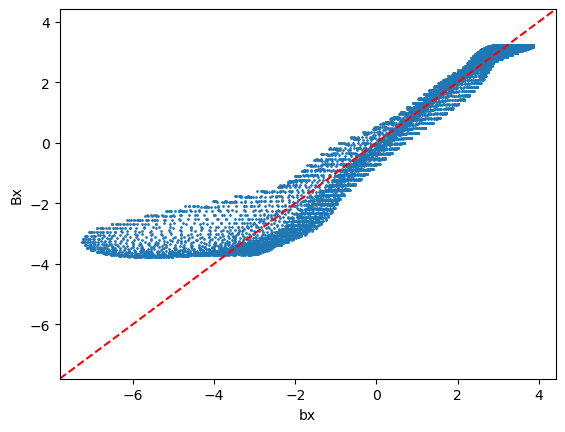

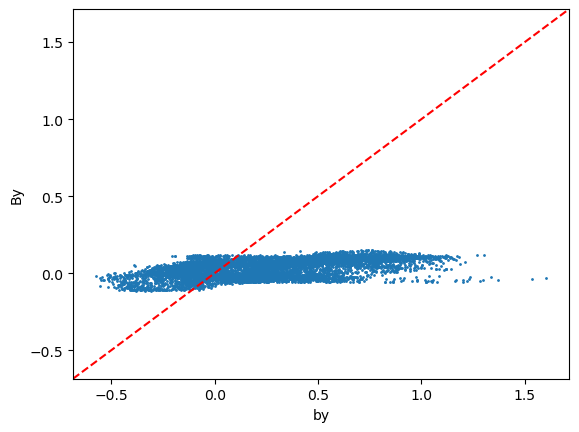

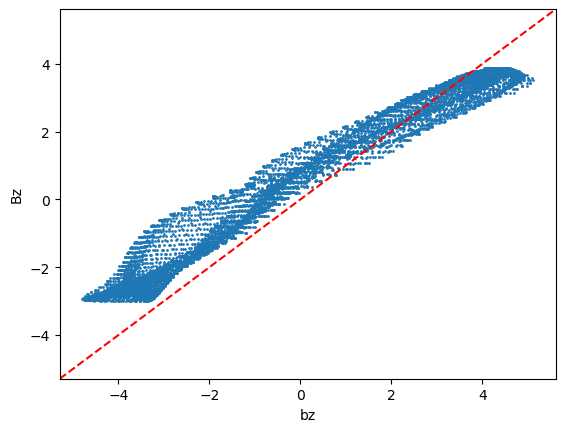

In [97]:
fig, ax = plt.subplots()
ax.scatter(b[::n, ::n, z, 0].flatten(), B[::n, ::n, z, 0].flatten(), s=1)
low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = min(low_x, low_y)
high = max(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c="red", alpha=1)
ax.set_xlabel('bx')
ax.set_ylabel('Bx')
ax.set_xlim([low, high])
ax.set_ylim([low, high])
plt.show()

fig, ax = plt.subplots()
ax.scatter(b[::n, ::n, z, 1].flatten(), B[::n, ::n, z, 1].flatten(), s=1)
low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = min(low_x, low_y)
high = max(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c="red", alpha=1)
ax.set_xlabel('by')
ax.set_ylabel('By')
ax.set_xlim([low, high])
ax.set_ylim([low, high])
plt.show()

fig, ax = plt.subplots()
ax.scatter(b[::n, ::n, z, 2].flatten(), B[::n, ::n, z, 2].flatten(), s=1)
low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = min(low_x, low_y)
high = max(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c="red", alpha=1)
ax.set_xlabel('bz')
ax.set_ylabel('Bz')
ax.set_xlim([low, high])
ax.set_ylim([low, high])
plt.show()

In [56]:
import numpy as np

In [61]:
xx = b[::4, ::4, z, 0].flatten()[None, :].astype(np.float32)
yy = B[::4, ::4, z, 0].flatten()[None, :].astype(np.float32)

xx.shape, yy.shape

((1, 8192), (1, 8192))

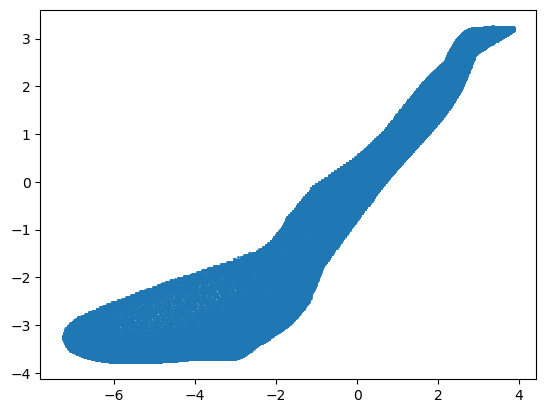

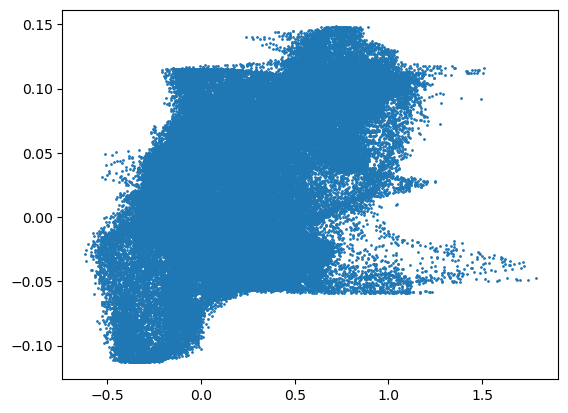

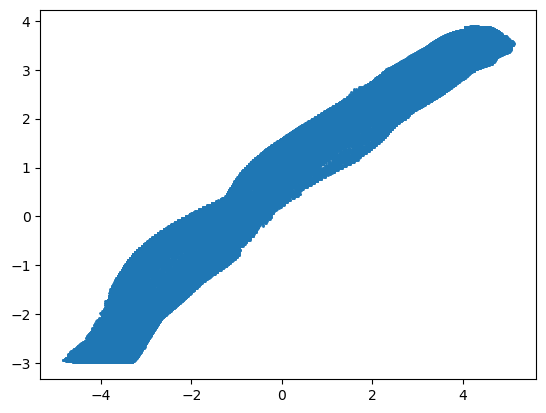

In [ ]:
plt.scatter(b[:, :, z, 0].flatten(), B[:, :, z, 0].flatten(), s=1)
plt.show()

plt.scatter(b[:, :, z, 1].flatten(), B[:, :, z, 1].flatten(), s=1)
plt.show()

plt.scatter(b[:, :, z, 2].flatten(), B[:, :, z, 2].flatten(), s=1)
plt.show()

In [ ]:
class Evaluator:
    def __init__(b, B):
        """
        b: [Nx, Ny, Nz, 3]; model solution
        B: [Nx, Ny, Nz, 3]; reference magnetic field
        """
        self.b = b
        self.B = B

    def dot_product():
        
    

def dot_product(a, b):
    """

    """

In [16]:
from rtmag.test.eval import evaluate

In [17]:
evaluate(b, B)

C_vec     : 0.9572
C_cs      : 0.8898
E_n'      : 0.6441
E_m'      : 0.2890
eps       : 0.8898
CW_sin    : 0.7929
L_f       : 55.4298
L_d       : 30.3140
l2_err    : 0.2899


{'C_vec': 0.9571648392623311,
 'C_cs': 0.8897902276110174,
 "E_n'": 0.6441443197777384,
 "E_m'": 0.28897252909746796,
 'eps': 0.8898441199943984,
 'CW_sin': 0.7929084600946821,
 'L_f': 55.42983657217508,
 'L_d': 30.31401056903346,
 'l2_err': 0.28988923595120397}

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plot_overview(b, B, z=0, b_norm=2500):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))

    ax = axs[0]
    ax[0].imshow(b[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('bx')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(b[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('by')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow(b[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('bz')
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax = axs[1]
    ax[0].imshow(B[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('Bx')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(B[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('By')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[2].imshow(B[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('Bz')
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    fig.suptitle(f'z={z}')
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot_s(mag, title, n_samples, v_mm=2500):
    fig, axs = plt.subplots(3, n_samples, figsize=(n_samples * 4, 12))
    heights = np.linspace(0, 1, n_samples) ** 2 * (mag.shape[2] - 1)  # more samples from lower heights
    heights = heights.astype(np.int32)
    for i in range(3):
        for j, h in enumerate(heights):
            v_min_max = int(v_mm / (h+1))
            axs[i, j].imshow(mag[:, :, h, i].transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max,
                            origin='lower')
            axs[i, j].set_axis_off()
    for j, h in enumerate(heights):
        axs[0, j].set_title('%.01f' % h, fontsize=20)
    fig.tight_layout()
    fig.suptitle(title, fontsize=25)
    plt.tight_layout()
    plt.show()

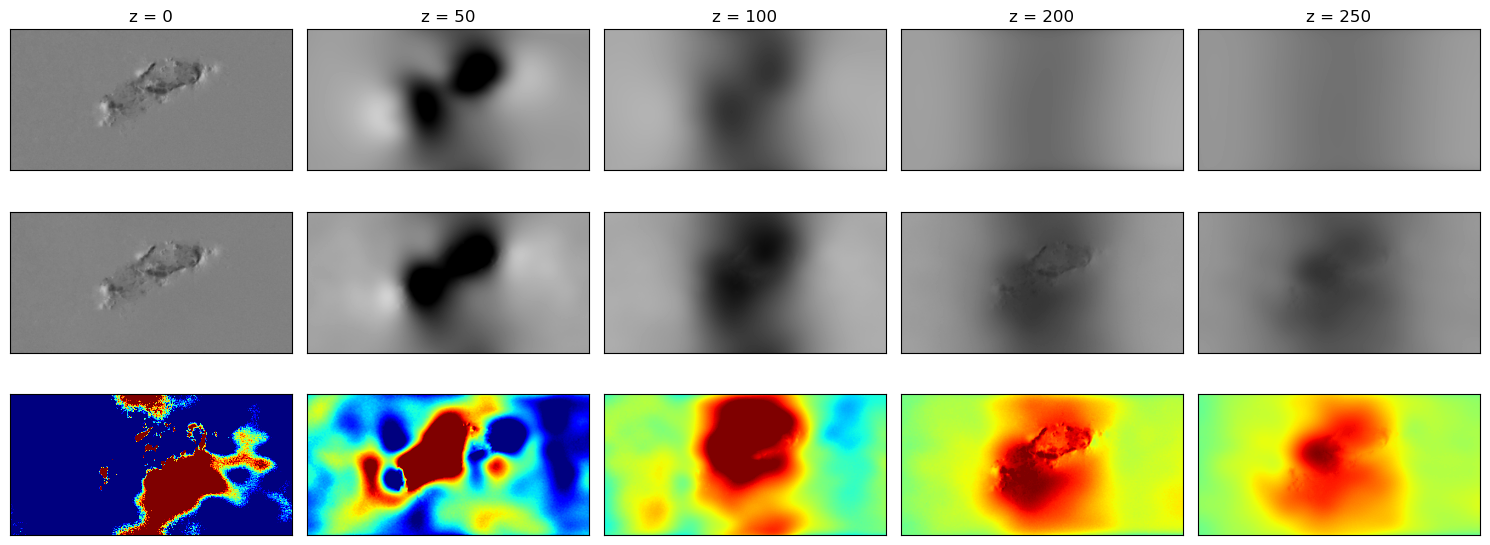

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some example data (you'll need your actual data here)
y_true = B[..., 0]
y_predicted = b[..., 0]
y_difference = y_true - y_predicted

# Create a 3x4 grid of subplots

plot_z = [0, 50, 100, 200, 250]

fig, axs = plt.subplots(3, len(plot_z), figsize=(3*len(plot_z), 6))

# Plot the true data
for i in range(len(plot_z)):
    axs[0, i].imshow(y_true[:, :, plot_z[i]].T, origin='lower', cmap='gray', label="True", vmin=-2500/(plot_z[i]+1), vmax=2500/(plot_z[i]+1))
    axs[0, i].set_title(f"z = {plot_z[i]}")

# Plot the predicted data
for i in range(len(plot_z)):
    axs[1, i].imshow(y_predicted[:, :, plot_z[i]].T, origin='lower', cmap='gray', label="p-CNN = all", vmin=-2500/(plot_z[i]+1), vmax=2500/(plot_z[i]+1))
    # axs[1, i].set_title(f"z = {i}")

# Plot the absolute difference
for i in range(len(plot_z)):
    im = axs[2, i].imshow(y_difference[:, :, plot_z[i]].T, origin='lower', cmap='jet', label="Absolute Difference", vmin=-5, vmax=5)
    # axs[2, i].set_title(f"z = {i}")

# Add labels, legends, and adjust spacing
for ax in axs.flat:
    # ax.set(xlabel="X", ylabel="Y")
    ax.set_xticks([])
    ax.set_yticks([])

# Add colorbars
# for i, ax in enumerate(axs.flat):
#     # Create colorbar
#     cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.005, ax.get_position().height])
#     fig.colorbar(im, cax=cax)
#     # Hide x and y axis ticks
#     ax.set_xticks([])
#     ax.set_yticks([])

plt.tight_layout()
# Adjust layout

# Show the plot
plt.show()


In [ ]:
from streamtracer import StreamTracer, VectorGrid

In [ ]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = 512
Ly = 256
numbers = 30
xyranges = [
    [0.33, 0.40, 0.38, 0.50],
    [0.50, 0.60, 0.50, 0.70],
    [0.65, 0.70, 0.70, 0.80],
]
grid_spacing = [1, 1, 1]

grid = VectorGrid(b, grid_spacing)
grid_true = VectorGrid(B, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)
    tracer.trace(seeds, grid_true)
    tracer_xs_true.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]
tracer_xs_true = [item for sublist in tracer_xs_true for item in sublist]